In [1]:
from tensorflow.keras.metrics import CategoricalAccuracy
from data_loader.batchgenerator import GTSRB_Generator,TT100K_Generator,FLICKR32_Generator
#from data_loader.generators import BELGA_Generator,TOPLOGO10_Generator,GTSRB_Generator,TT100K_Generator,PERSIAN_Generator
import time
from models.makemodels import make_proto_model
from utils import load_config
from models.losses import loss_mse
import tensorflow as tf
from data_loader import get_loader
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import numpy as np
from models import resnet12

ImportError: cannot import name 'stn2' from 'models.stn2' (D:\MTPNet\models\stn2.py)

In [2]:
clf = make_proto_model(backbone='resnet12',input_shape=(64,64,3))

In [10]:
from models.blocks import res_block,conv_block,dcp
from models.stn import stn
from models.distances import Euclidean_Distance
from tensorflow import keras

In [11]:
def create_resnet(input_shape = (64,64,3)):
    H,W,C = input_shape
    inp = keras.layers.Input([H,W,C])
    resnet = resnet12.create_resnet12(input_shape=input_shape)
    resnet.load_weights('model_files/pretrained_weights/resnet12_enc_tiered.h5')
    res_encoder = keras.Model(inputs=resnet.inputs,outputs=resnet.get_layer('maxpool_stage_2').output,name='backbone')
    x = res_encoder(inp)
    x = keras.layers.Conv2D(
        kernel_size=(1,1),filters=100,padding='same',kernel_initializer='he_normal')(x)
    x = stn(x,filters=[100,100,100])
    x = conv_block(x,kernel_size=(5,5),n_filters=100,strides=(1,1))
    x = dcp(x,n_filters=100,kernel_size=(3,3))
    x = keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(units=300,activation='linear',kernel_initializer="he_normal")(x)
    return keras.Model(inp,x,name='encoder')

In [12]:
clf = create_resnet()

In [ ]:
import joblib
joblib.dump(clf, 'cl.h5')  # Save


INFO:tensorflow:Assets written to: ram://f531a9c2-f489-468d-ac29-3102906be6e7/assets


INFO:tensorflow:Assets written to: ram://f531a9c2-f489-468d-ac29-3102906be6e7/assets


In [ ]:
model = joblib.load('cl.h5') # Load

In [13]:
clf.save('clf.h5')

In [36]:
keras.models.load_model('clf.h5',compile=False)

IndexError: list index out of range

In [18]:
cl2 = tf.saved_model.load('clf')

In [24]:
infer = cl2.signatures["serving_default"]

In [27]:
X = tf.ones((128,64,64,3))

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(clf)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Nariman\AppData\Local\Temp\tmpox_07vuf\assets


In [34]:
tflite_model(X)

TypeError: 'bytes' object is not callable

In [44]:
clf.load_weights('model_files/best_densenet_gtsrb2tt100k_14011024.h5')

In [45]:
clf.get_layer('encoder').output

<KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'dense_5')>

In [46]:
inp = keras.layers.Input((64,64,3))
enc = keras.Model(inputs=clf.get_layer('encoder').input,outputs=clf.get_layer('encoder').output)

In [9]:
x = tf.ones((64,64,3))

In [47]:
loader = get_loader('gtsrb2tt100k') 
test_generator = loader.get_test_generator(batch=128,dim=64,type='tt100k')

Loading all data


In [48]:
t = iter(test_generator)

In [67]:
[Xs,Xq],y = next(t)

In [50]:
Zs = enc(Xs)
Zs.shape

TensorShape([36, 300])

In [68]:
Zq = enc(Xq)
Zq.shape

TensorShape([128, 300])

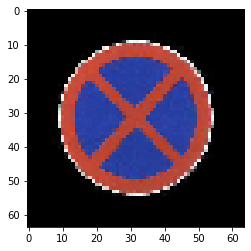

In [26]:
plt.imshow(Xs[0]/255)

In [52]:
y_train = to_categorical(np.arange(36),num_classes=36)

In [53]:
from sklearn.neighbors import KNeighborsClassifier

In [91]:
knn = KNeighborsClassifier(n_neighbors=1,n_jobs=-1,metric='l2')

In [92]:
knn.fit(Zs,y_train);

In [93]:
knn.score(Zq,y_test)

0.796875

In [71]:
from tqdm import tqdm

In [94]:
acc = 0
y_train = to_categorical(np.arange(36),num_classes=36)
for z in tqdm(test_generator):
    [Xs,Xq],y_test = z
    Zq = enc(Xq)
    acc += knn.score(Zq,y_test)
acc / len(test_generator)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [00:27<00:00,  3.40it/s]


0.8197244623655914

In [59]:
len(test_generator)

93

In [95]:
enc.save('encoder.h5')

In [96]:
fe = keras.models.load_model('encoder.h5')

IndexError: list index out of range

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPooling2D,Conv2D,Flatten,Dense,Input,GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow import keras

class Localization(tf.keras.layers.Layer):
    def __init__(self, 
                 filters_1: int, 
                 filters_2: int, 
                 fc_units: int, 
                 kernel_size=(5,5),
                 pool_size=(2,2),
                 name='localization', 
                 **kwargs):
        super(Localization, self).__init__(**kwargs)
        self.filters_1 = filters_1
        self.filters_2 = filters_2
        self.fc_units = fc_units
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.network = keras.Sequential(
            [
                MaxPooling2D(pool_size=pool_size, name=name+'_mp_1'),
                Conv2D(filters=filters_1, 
                       kernel_size=kernel_size, 
                       padding='same', 
                       strides=1, 
                       activation='relu',
                       name=name+'_c_1'),
                MaxPooling2D(pool_size=pool_size, name=name+'_mp_2'),
                Conv2D(filters=filters_2, 
                       kernel_size=kernel_size, 
                       padding='same', 
                       strides=1, 
                       activation='relu',
                       name=name+'_c_2'),
                MaxPooling2D(pool_size=pool_size, name=name+'_mp_3'),
                Flatten(name=name+'_fl'),
                Dense(fc_units, activation='relu', name=name+'_d_1'),
                Dense(6, activation=None, 
                      bias_initializer=tf.keras.initializers.constant\
                      ([1.0, 0.0, 0.0, 0.0, 1.0, 0.0]), 
                      kernel_initializer='zeros',
                      name=name+'_d_2'),
            ]
        )

    def build(self, input_shape):
        print("Building Localization Network with input shape:", input_shape)

    def compute_output_shape(self, input_shape):
        return [None, 6]

    def call(self, inputs):
        theta = self.network(inputs)
        theta = tf.keras.layers.Reshape((2, 3))(theta)
        return theta

    def get_config(self):
        config = super(Localization, self).get_config()
        config.update({
            'filters_1': self.filters_1,
            'filters_2': self.filters_2,
            'fc_units': self.fc_units,
            'kernel_size': self.kernel_size,
            'pool_size': self.pool_size,
        })
        return config
     
class BilinearInterpolation(tf.keras.layers.Layer):
    def __init__(self, height=48, width=48):
        super(BilinearInterpolation, self).__init__()
        self.height = height
        self.width = width

    def compute_output_shape(self, input_shape):
        return [None, self.height, self.width, 1]

    def get_config(self):
        return {
            'height': self.height,
            'width': self.width,
        }
    
    def build(self, input_shape):
        print("Building Bilinear Interpolation Layer with input shape:", input_shape)

    def advance_indexing(self, inputs, x, y):
        '''
        Utility function to get pixel value for coordinate
        vectors x and y from a  4D tensor image.
        '''        
        shape = tf.shape(inputs)
        batch_size, _, _ = shape[0], shape[1], shape[2]
        
        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
        b = tf.tile(batch_idx, (1, self.height, self.width))
        indices = tf.stack([b, y, x], 3)
        return tf.gather_nd(inputs, indices)

    def call(self, inputs):
        images, theta = inputs
        sampling_grid = self.grid_generator(batch=tf.shape(images)[0])
        return self.interpolate(images, sampling_grid, theta)

    def grid_generator(self, batch):
        '''
        This function returns a sampling grid, which when
        used with the bilinear sampler on the input feature
        map, will create an output feature map that is an
        affine transformation of the input feature map.
        '''
        # create normalized 2D grid
        x = tf.linspace(-1, 1, self.width)
        y = tf.linspace(-1, 1, self.height)
        # x and y are selected in the range of -1 to 1 so the the transformation happens considering the center
        # of the image as the origin. The images will be later scaled up.
        xx, yy = tf.meshgrid(x, y)
            
        # flatten
        xx = tf.reshape(xx, (-1,))
        yy = tf.reshape(yy, (-1,))

        # reshape to [x_t, y_t , 1] - (homogeneous form)
        homogenous_coordinates = tf.stack([xx, yy, tf.ones_like(xx)])
        # # repeat grid num_batch times
        # sampling_grid = np.resize(sampling_grid, (num_batch, 3, H*W))
        # repeat grid num_batch times
        homogenous_coordinates = tf.expand_dims(homogenous_coordinates, axis=0)
        homogenous_coordinates = tf.tile(homogenous_coordinates, tf.stack([batch, 1, 1]))
        # homogenous_coordinates = tf.tile(homogenous_coordinates, [batch, 1, 1])

        # cast to float32 (required for matmul)
        homogenous_coordinates = tf.cast(homogenous_coordinates, dtype=tf.float32)

        return homogenous_coordinates
    
    def interpolate(self, images, grid, theta):
        '''
        Performs bilinear sampling of the input images according to the
        normalized coordinates provided by the sampling grid. Note that
        the sampling is done identically for each channel of the input.
        '''

        with tf.name_scope("Transformation"):
            # transform the sampling grid - batch multiply
            transformed = tf.matmul(theta, grid)
            # batch grid has shape (num_batch, 2, H*W)

            # reshape to (num_batch, H, W, 2)
            transformed = tf.transpose(transformed, perm=[0, 2, 1])
            transformed = tf.reshape(transformed, [-1, self.height, self.width, 2])
                
            x_transformed = transformed[:, :, :, 0]
            y_transformed = transformed[:, :, :, 1]
                
            # rescale x and y to [0, W-1/H-1]
            x = ((x_transformed + 1.) * tf.cast(self.width, dtype=tf.float32)) * 0.5
            y = ((y_transformed + 1.) * tf.cast(self.height, dtype=tf.float32)) * 0.5

        with tf.name_scope("VariableCasting"):
            # grab 4 nearest corner points for each (x_i, y_i)
            x0 = tf.cast(tf.math.floor(x), dtype=tf.int32)
            x1 = x0 + 1
            y0 = tf.cast(tf.math.floor(y), dtype=tf.int32)
            y1 = y0 + 1

            # clip to range [0, H-1/W-1] to not violate img boundaries
            x0 = tf.clip_by_value(x0, 0, self.width-1)
            x1 = tf.clip_by_value(x1, 0, self.width-1)
            y0 = tf.clip_by_value(y0, 0, self.height-1)
            y1 = tf.clip_by_value(y1, 0, self.height-1)
            x = tf.clip_by_value(x, 0, tf.cast(self.width, dtype=tf.float32)-1.0)
            y = tf.clip_by_value(y, 0, tf.cast(self.height, dtype=tf.float32)-1)

        with tf.name_scope("AdvanceIndexing"):
            # get pixel value at corner coords
            Ia = self.advance_indexing(images, x0, y0)
            Ib = self.advance_indexing(images, x0, y1)
            Ic = self.advance_indexing(images, x1, y0)
            Id = self.advance_indexing(images, x1, y1)

        with tf.name_scope("Interpolation"):
            # recast as float for delta calculation
            x0 = tf.cast(x0, dtype=tf.float32)
            x1 = tf.cast(x1, dtype=tf.float32)
            y0 = tf.cast(y0, dtype=tf.float32)
            y1 = tf.cast(y1, dtype=tf.float32)
                            
            # calculate deltas
            wa = (x1-x) * (y1-y)
            wb = (x1-x) * (y-y0)
            wc = (x-x0) * (y1-y)
            wd = (x-x0) * (y-y0)

            # add dimension for addition
            wa = tf.expand_dims(wa, axis=3)
            wb = tf.expand_dims(wb, axis=3)
            wc = tf.expand_dims(wc, axis=3)
            wd = tf.expand_dims(wd, axis=3)
                        
        return tf.math.add_n([wa*Ia + wb*Ib + wc*Ic + wd*Id])

In [10]:
from tensorflow.keras.applications import DenseNet121
from models.blocks import conv_block,dcp

In [24]:
def stn(x):
    theta = Localization(100,100,100)(x)
    h,w = [x.shape[1],x.shape[2]]
    return BilinearInterpolation(height=h,width=w)([x, theta]) 

In [25]:
inp = keras.layers.Input((64,64,3))
densnet = DenseNet121(input_shape=(64,64,3),weights='imagenet',include_top=False)
dens_encoder = keras.Model(inputs=densnet.inputs,outputs=densnet.get_layer('conv3_block1_concat').output)
x = dens_encoder(inp)
x = keras.layers.Conv2D(kernel_size=(1,1),filters=100,padding='same',kernel_initializer='he_normal')(x)
x = stn(x)
x = conv_block(x,kernel_size=(3,3),n_filters=100,strides=(1,1))
x = dcp(x,n_filters=100,kernel_size=(3,3))
x = keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(units=400,activation='linear',kernel_initializer="he_normal")(x)
c = keras.Model(inp,outputs=x,name='encoder')

Building Localization Network with input shape: (None, 8, 8, 100)
Building Bilinear Interpolation Layer with input shape: [TensorShape([None, 8, 8, 100]), TensorShape([None, 2, 3])]


In [26]:
c.save('test.h5')

In [27]:
c2 = keras.models.load_model('test.h5',custom_objects={'Localization':Localization,'BilinearInterpolation':BilinearInterpolation})

Building Localization Network with input shape: (None, 8, 8, 100)
Building Bilinear Interpolation Layer with input shape: [TensorShape([None, 8, 8, 100]), TensorShape([None, 2, 3])]


In [28]:
c2.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 model_5 (Functional)           (None, 8, 8, 160)    436032      ['input_14[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 8, 8, 100)    16100       ['model_5[0][0]']                
                                                                                                  
 localization_8 (Localization)  (None, 2, 3)         510906      ['conv2d_16[0][0]']              
                                                                                            